In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pl
from sqlalchemy import create_engine, text
from scipy.stats import zscore
import psycopg2
import os
import plotly.graph_objects as go
import plotly.express as px

In [2]:
os.chdir('..')

In [3]:
from db.connection import DatabaseConnection
from db.sql_preprocessor import DBFilter
from src.plot_utils import set_seaborn_style, plot_histogram_kde, plot_boxplot, plot_time_series, plot_countplot

In [4]:
db_connection = DatabaseConnection()

In [5]:
db_connection.connect()

Connected to the database.


In [6]:
query = "SELECT * FROM xdr_data"
df = db_connection.execute_query(query)

In [7]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [8]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [9]:
missing_values = df.isnull().sum()
print(missing_values)

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [10]:
duplicates = df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


In [22]:
top_handsets = df.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name='count')
top_handsets = top_handsets.sort_values(by='count', ascending=False).head(10)

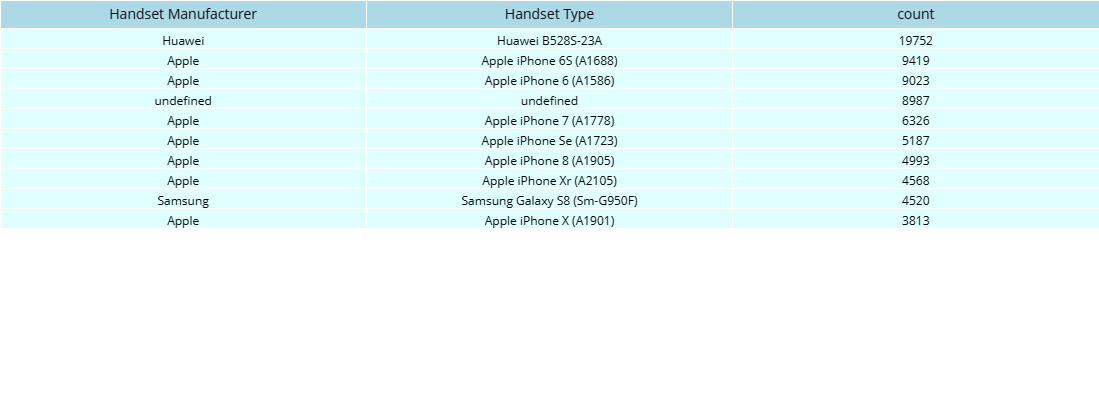

In [24]:
table_data = top_handsets[['Handset Manufacturer', 'Handset Type', 'count']]

# Create a Table object
table = go.Figure(data=[go.Table(
    header=dict(values=list(table_data.columns),
                fill_color='lightblue',
                align='center',
                font=dict(color='black', size=14)),
    cells=dict(values=[table_data['Handset Manufacturer'], table_data['Handset Type'], table_data['count']],
               fill=dict(color=['lightcyan', 'lightcyan', 'lightcyan']),
               align='center',
               font=dict(color='black', size=12)))
])

# Set layout properties
table.update_layout(width=800, height=400, margin=dict(l=0, r=0, t=0, b=0))

# Show the table
table.show()

In [13]:
# We shall clean the data for the unidefined 

In [61]:
top_handsets = df.query("`Handset Manufacturer` != 'undefined' and `Handset Type` != 'undefined'")[['Handset Manufacturer', 'Handset Type']]

In [62]:
top_handsets = top_handsets.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name='count')
top_handsets = top_handsets.sort_values(by='count', ascending=False).head(10)

In [63]:
top_handsets[['Handset Manufacturer', 'Handset Type', 'count']]

,Handset Manufacturer,Handset Type,count
316,Huawei,Huawei B528S-23A,19752
60,Apple,Apple iPhone 6S (A1688),9419
56,Apple,Apple iPhone 6 (A1586),9023
66,Apple,Apple iPhone 7 (A1778),6326
80,Apple,Apple iPhone Se (A1723),5187
73,Apple,Apple iPhone 8 (A1905),4993
85,Apple,Apple iPhone Xr (A2105),4568
957,Samsung,Samsung Galaxy S8 (Sm-G950F),4520
82,Apple,Apple iPhone X (A1901),3813
840,Samsung,Samsung Galaxy A5 Sm-A520F,3724


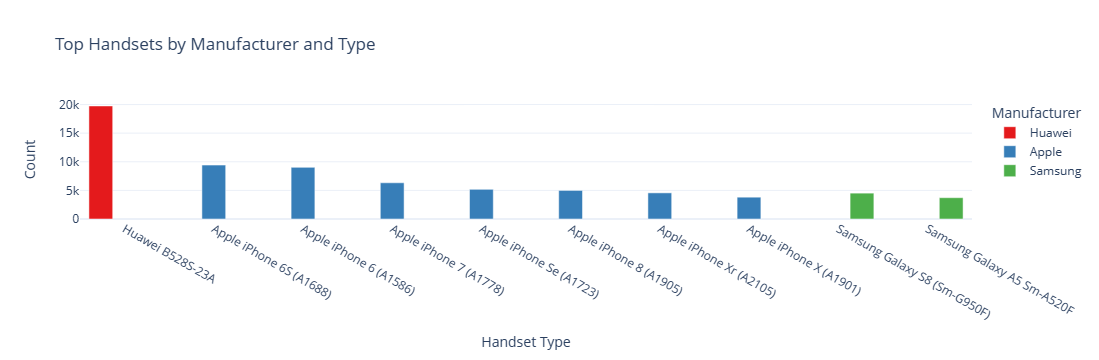

In [66]:
# Create an interactive bar plot with Plotly Express
fig = px.bar(top_handsets, x='Handset Type', y='count', color='Handset Manufacturer',
             labels={'count': 'Count', 'Handset Type': 'Handset Type'},
             title='Top Handsets by Manufacturer and Type',
             template='plotly_white',  # Light theme
             color_discrete_sequence=px.colors.qualitative.Set1)  # Custom color palette

# Customize the layout
fig.update_layout(
    xaxis=dict(title='Handset Type'),
    yaxis=dict(title='Count'),
    legend=dict(title='Manufacturer'),
    barmode='group',
    showlegend=True
)

# Show the plot
fig.show()

In [44]:
top_manufacturers = df[df['Handset Manufacturer'] != 'undefined']

In [45]:
top_manufacturers = top_manufacturers['Handset Manufacturer'].value_counts().head(3).reset_index(name='count')

In [46]:
top_manufacturers.columns = ['Handset Manufacturer', 'count']
top_manufacturers

,Handset Manufacturer,count
0,Apple,59565
1,Samsung,40839
2,Huawei,34423


In [47]:
len(top_manufacturers)

3

In [48]:
# Calculate the percentage of each top manufacturer
total_rows = len(df)
top_manufacturers['percentage'] = (top_manufacturers['count'] / total_rows) * 100

# Display the top manufacturers with their counts and percentages
print(top_manufacturers)

  Handset Manufacturer  count  percentage
0                Apple  59565   39.709735
1              Samsung  40839   27.225818
2               Huawei  34423   22.948514


In [50]:
# Count the total number of handsets in the entire dataset
total_handsets = df['Handset Type'].count()

# Display the total number of handsets
print("Total number of handsets:", total_handsets)


Total number of handsets: 149429


In [20]:
top_manufacturers = df[df['Handset Manufacturer'] != 'undefined']

In [21]:
top_manufacturers = top_manufacturers['Handset Manufacturer'].value_counts().head(3).index

In [22]:
filtered_df = df[df['Handset Manufacturer'].isin(top_manufacturers)]

In [23]:
top_handsets_per_manufacturer = (
    filtered_df.groupby(['Handset Manufacturer', 'Handset Type'])
    .size()
    .reset_index(name='count')
    .sort_values(by=['Handset Manufacturer', 'count'], ascending=[True, False])
    .groupby('Handset Manufacturer')
    .head(5)
)

In [24]:
top_handsets_per_manufacturer

,Handset Manufacturer,Handset Type,count
35,Apple,Apple iPhone 6S (A1688),9419
31,Apple,Apple iPhone 6 (A1586),9023
41,Apple,Apple iPhone 7 (A1778),6326
55,Apple,Apple iPhone Se (A1723),5187
48,Apple,Apple iPhone 8 (A1905),4993
83,Huawei,Huawei B528S-23A,19752
104,Huawei,Huawei E5180,2079
183,Huawei,Huawei P20 Lite Huawei Nova 3E,2021
182,Huawei,Huawei P20,1480
224,Huawei,Huawei Y6 2018,997
